In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

import warnings
import re
import os
import time
import pickle

%matplotlib inline

|computer|skl.__version__| sns.__version__| pd.__version__|np.__version__|
|---|---|---|---|---|
|sctms |'0.22.1'| '0.10.0'| '1.0.1'|'1.18.1' |
|toshiba |'0.22.1'| '0.9.0'| '0.25.1'|'1.18.1'|

In [2]:
skl.__version__, sns.__version__, pd.__version__, np.__version__

('0.22.1', '0.10.0', '1.0.1', '1.18.1')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, get_scorer

from sklearn.externals import joblib

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
from ML_helper_functions import *

In [5]:
warnings.filterwarnings(action='ignore')
sns.set_context('talk')

In [6]:
dpi = 200

# Get data, train models

## datamatrix loading

Load datamatrices

In [7]:
yXs = []

for i, name in enumerate(['dim', 'TD10', 'ring_size']):
    yx = joblib.load(f'yX_{name}.dtm')
    print(f'{name} data loaded: {yx.shape}')
    yXs.append(yx)

y1X, y2X, y4X = yXs

dim data loaded: (5720, 11)
TD10 data loaded: (1158, 11)
ring_size data loaded: (1010, 11)


Rewrite:
- https://github.com/rasbt/model-eval-article-supplementary/blob/master/code/nested_cv_code.ipynb

On nested CV and model training
- https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection/65158#65158
- https://stats.stackexchange.com/questions/232897/how-to-build-the-final-model-and-tune-probability-threshold-after-nested-cross-v/233027#233027
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
- https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

Biases:
- https://www.nature.com/articles/s41586-019-1540-5

Make training-evaluating function

## Model training, tuning, assesment

**Model comparison using nested 5x5 cross-validation**

*TODO

- check straw models with X random
- compare models performances with Dummy classifier performmance

In [9]:
def eval_target(dm, parallel=-1, scoring='f1_macro', RST=23):
    
    # F1 for binary classifiaction
    # https://datascience.stackexchange.com/questions/85182/macro-and-micro-average-for-imbalanced-binary-classes
    
    RST = RST

    lr = LogisticRegression(class_weight='balanced', penalty='l2', random_state=RST)
    dt = DecisionTreeClassifier(random_state=RST)
    rfc = RandomForestClassifier(random_state=RST)
    svm = SVC(cache_size=750, class_weight='balanced', random_state=RST, kernel='rbf')
    gbc = GradientBoostingClassifier(random_state=RST)
    dmm = DummyClassifier(random_state=RST)



    lr_param_grid = {'C': np.logspace(-3, 3, 7)}

    dt_param_grid = {'max_depth': list(range(4, 10)) + [None],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_leaf': [3, 4, 5]}

    rf_param_grid = {'n_estimators': (100, 250, 500),
                     'max_depth': (10, None)}

    svm_param_grid = {'C': np.logspace(-2, 2, 5),
                      'gamma': np.logspace(-4, 1, 6)}
                      
    gbc_param_grid = {'n_estimators': (100, 250, 500),
                      'max_depth': (2, 3),
                      'learning_rate': (0.33, 1.0, 3.0)}

    dmm_param_grid = {'strategy': ('stratified', 'most_frequent', 'uniform')}


    # for nested 5x5 cv and final model training
    X, y = dm.iloc[:, 1:], dm.iloc[:, 0].astype(int)
    # for checking straw models make Xij take values from [-1; 1)
#     np.random.seed(RST)
#     X, y = 2*np.random.random_sample(dm.iloc[:, 1:].shape) - 1, dm.iloc[:, 0].astype(int) 

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.2,
                                                        stratify=y,
                                                        random_state=RST) # for model analysis



    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gridcvs = {}
    s5f = StratifiedKFold(n_splits=5, shuffle=True, random_state=RST)    

    for est, est_param, name in zip(
                                    (lr, dt, rfc, svm, gbc, dmm),
                                    (lr_param_grid, dt_param_grid, rf_param_grid, svm_param_grid, gbc_param_grid, dmm_param_grid),
                                    ('LR', 'DT', 'RF', 'SVC', 'GBC', 'DUM')
                                   ):

        gcv = GridSearchCV(estimator=est,
                           param_grid=est_param,
                           scoring=scoring,
                           n_jobs=parallel,
                           cv=s5f,
                           refit=True)
        gridcvs[name] = gcv

    Q = {}
    estimators = {}
    for name, gs_est in sorted(gridcvs.items()):
        start = time.time()
        nested_score = cross_val_score(gs_est,
                                       X=X,
                                       y=y,
                                       cv=s5f,
                                       scoring=scoring,
                                       n_jobs=parallel)
        print('Algorithm selection with nested cross-validation')
        print('Nested CV results: %-4s | outer %s |||%.2f%% +/- %.2f|||' % (name, scoring, nested_score.mean() * 100, nested_score.std() * 100))
        print('Time elapsed: %.3f sec' % (time.time() - start))
        print('\n')

        est_grid_cv = gridcvs[name]
        est_grid_cv.fit(X=X_train, y=y_train)
        print('%s %.2f%% (average over CV test folds)' % (scoring, 100 * est_grid_cv.best_score_))
        print('Best Parameters |||ALL DATA USED HERE|||: %s' % est_grid_cv.best_params_)
        print('Confusion matrix\n', confusion_matrix(y_test, est_grid_cv.best_estimator_.predict(X_test)))
        print('Classification Report\n', classification_report(y_test, est_grid_cv.best_estimator_.predict(X_test)))

        estimators[name] = est_grid_cv.predict(X_test)

        print('\n%s\n' % (70*'*'))


        Q[name] = [
                   nested_score.mean(), nested_score.std(),
                   est_grid_cv.best_params_,
                   confusion_matrix(y_test, est_grid_cv.best_estimator_.predict(X_test)),
                   classification_report(y_test, est_grid_cv.best_estimator_.predict(X_test), output_dict=True)
                  ]

        # Fitting a model to the whole dataset
        # using estimator with the "best" hyperparameter settings
        gridcvs[name] = est_grid_cv.best_estimator_.fit(X, y)

    return gridcvs, Q, estimators

- precision maximization resulted in lower model quality (in predicting 1st class) for both dim and TD10 prediction
- по сравнению с dummy классификатором все модели выдают лучшее качество классификации

In [10]:
# f1_macro
model_dicts = {}
model_quality = {}
estimators_trained_on_Xtrain = {}

for name, yx in zip(['dim', 'TD10', 'ring_size'], [y1X, y2X, y4X]):

    print('\n%s\n' % (70*'#'))
    print(name, 'prediction')
    print('\n%s\n' % (70*'#'))

    model_dicts[name], model_quality[name], estimators_trained_on_Xtrain[name] = eval_target(yx)


######################################################################

dim prediction

######################################################################

Algorithm selection with nested cross-validation
Nested CV results: DT   | outer f1_macro |||48.15% +/- 1.96|||
Time elapsed: 6.839 sec


f1_macro 48.16% (average over CV test folds)
Best Parameters |||ALL DATA USED HERE|||: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}
Confusion matrix
 [[ 20  63   2]
 [ 58 877  39]
 [  2  62  21]]
Classification Report
               precision    recall  f1-score   support

          -1       0.25      0.24      0.24        85
           0       0.88      0.90      0.89       974
           1       0.34      0.25      0.29        85

    accuracy                           0.80      1144
   macro avg       0.49      0.46      0.47      1144
weighted avg       0.79      0.80      0.79      1144


**********************************************************************

Algorithm

Algorithm selection with nested cross-validation
Nested CV results: RF   | outer f1_macro |||57.33% +/- 2.09|||
Time elapsed: 31.812 sec


f1_macro 56.68% (average over CV test folds)
Best Parameters |||ALL DATA USED HERE|||: {'max_depth': None, 'n_estimators': 500}
Confusion matrix
 [[ 23  26   6]
 [ 10 101  11]
 [  9  20  26]]
Classification Report
               precision    recall  f1-score   support

          -1       0.55      0.42      0.47        55
           0       0.69      0.83      0.75       122
           1       0.60      0.47      0.53        55

    accuracy                           0.65       232
   macro avg       0.61      0.57      0.59       232
weighted avg       0.63      0.65      0.63       232


**********************************************************************

Algorithm selection with nested cross-validation
Nested CV results: SVC  | outer f1_macro |||57.39% +/- 3.77|||
Time elapsed: 6.734 sec


f1_macro 55.80% (average over CV test folds)
Best Para

#### dim prediction examination

In [11]:
_, X_test_dim, _, y_test_dim = train_test_split(y1X.iloc[:, 1:], y1X.iloc[:, 0],
                                                test_size=.2,
                                                stratify=y1X.iloc[:, 0],
                                                random_state=23)

In [12]:
X_test_dim.shape, y_test_dim.shape

((1144, 10), (1144,))

In [13]:
inp = pd.read_csv('deltas_overall.txt', sep='\t', index_col=0)

In [14]:
dim_dm = pd.concat([X_test_dim, y_test_dim, inp[inp.index.isin(y_test_dim.index)]['dD']], axis=1)

In [15]:
dim_dm.shape, X_test_dim.shape

((1144, 12), (1144, 10))

In [16]:
for est_name, prediction in estimators_trained_on_Xtrain['dim'].items():
    dim_dm[f'{est_name}_pred'] = prediction

In [17]:
dim_dm.head(2)

,nConf20,RotRatio,HybRatio,TopoPSA,LabuteASA,IC1,BalabanJ,Kier3,NHOHCount,nHBAcc,dim,dD,DT_pred,DUM_pred,GBC_pred,LR_pred,RF_pred,SVC_pred
[C9 H20 P1 1+_(338)]_JAKBUV..[C8 H19 Cl1 P1 1+_(166)]_RIYHOZ|Mn_C2N3[B2]{1002}_A*B2)3,0.0,0.0,0.222222,0.0,0.065476,-0.226998,0.000000,0.00,0.0,0.0,0.0,3_3,0,1,0,1,0,0
[C1 F3 O3 S1 1-_(22)]_DATGEM..[C10 H6 O6 S2 2-_(37)]_EBEKUT|Ag_C7H6N2[B2]{36844}_A*B2)2,1.0,1.0,-1.000000,0.0,0.170662,0.179059,-0.452562,0.25,0.0,0.0,0.0,1_1,0,0,0,-1,0,0


In [18]:
dim_dm['dD'].value_counts()

1_1    558
3_3    217
2_2    199
1_2     85
1_3     48
2_3     37
Name: dD, dtype: int64

In [19]:
dim_dm.groupby('dD')[['GBC_pred', 'dim']].count()

,GBC_pred,dim
dD,,
1_1,558,558
1_2,85,85
1_3,48,48
2_2,199,199
2_3,37,37
3_3,217,217


In [20]:
l = []

for deltaD_pred in ['DT_pred', 'DUM_pred', 'GBC_pred', 'LR_pred', 'RF_pred', 'SVC_pred']:
    print(deltaD_pred)
    temp = dim_dm[['dD', deltaD_pred, 'dim']]
    temp['acc'] = temp[['dim', deltaD_pred]].apply(lambda x: 'right_prediction' if x[0] == x[1] else 'wrong_prediction', axis=1)
    grouped = temp.groupby('dD')['acc'].value_counts()/temp.groupby('dD')['acc'].count()
    grouped.name = deltaD_pred
#     print(grouped)
    l.append(grouped)

DT_pred
DUM_pred
GBC_pred
LR_pred
RF_pred
SVC_pred


In [21]:
pd.concat(l, axis=1).style.format('{:.1%}')

#### continue

Модели, обученные на рандомном признаковом описании с настоящимии метками классов показывают качество неотличимое от dummy классификатора.

In [11]:
joblib.dump(model_dicts, 'trained_models_Xtrue.pkl')
joblib.dump(model_quality, 'trained_models_q_data_Xtrue.pkl')

['trained_models_q_data_Xtrue.pkl']

# Analyze models

## describe model performance

In [7]:
model_dicts_loaded = joblib.load('trained_models_Xtrue.pkl')
model_qs_loaded = joblib.load('trained_models_q_data_Xtrue.pkl')
yXs = []

for i, name in enumerate(['dim', 'TD10', 'ring_size']):
    yx = joblib.load(f'yX_{name}.dtm')
    print(f'{name} data loaded: {yx.shape}')
    yXs.append(yx)

y1X, y2X, y4X = yXs

dim data loaded: (5720, 11)
TD10 data loaded: (1158, 11)
ring_size data loaded: (1010, 11)


In [8]:
multidx = pd.MultiIndex.from_product([model_qs_loaded.keys(), model_qs_loaded['dim'].keys()])

summary = pd.DataFrame(index=multidx,
                       data=[model_qs_loaded[target][model] for target in model_qs_loaded.keys() for model in model_qs_loaded[target].keys()],
                       columns=['n5x5_cv_mean', 'n5x5_cv_std',
                                'best_params_',
                                'confusion_matrix', 'class_report']
                        )

In [9]:
summary['precision_-1'] = summary['class_report'].apply(lambda x: x['-1']['precision'])
summary['recall_-1'] = summary['class_report'].apply(lambda x: x['-1']['recall'])
summary['F1_-1'] = summary['class_report'].apply(lambda x: x['-1']['f1-score'])

summary['precision_0'] = summary['class_report'].apply(lambda x: x['0']['precision'])
summary['recall_0'] = summary['class_report'].apply(lambda x: x['0']['recall'])
summary['F1_0'] = summary['class_report'].apply(lambda x: x['0']['f1-score'])

summary['precision_1'] = summary['class_report'].apply(lambda x: x['1']['precision'])
summary['recall_1'] = summary['class_report'].apply(lambda x: x['1']['recall'])
summary['F1_1'] = summary['class_report'].apply(lambda x: x['1']['f1-score'])

summary['precision'] = (summary['precision_-1'] + summary['precision_0'] + summary['precision_1'])/3
summary['recall'] = (summary['recall_-1'] + summary['recall_0'] + summary['recall_1'])/3
summary['F1'] = (summary['F1_-1'] + summary['F1_0'] + summary['F1_1'])/3

In [10]:
dq = summary.style\
            .format({k: '{:.1%}' for k in summary.dtypes[(summary.dtypes == 'float64')].index.values.tolist()})\
            .bar(subset=['n5x5_cv_mean',
                         'precision_-1', 'recall_-1', 'F1_-1',
                         'precision_0', 'recall_0', 'F1_0',
                         'precision_1', 'recall_1', 'F1_1',
                         'precision', 'recall', 'F1'], color='#2e8b57', vmin=0, vmax=1)
# dq.to_excel('models_new_Xtrue.xlsx', float_format='%.4f')
dq

In [11]:
summary.loc['dim'].index

Index(['DT', 'DUM', 'GBC', 'LR', 'RF', 'SVC'], dtype='object')

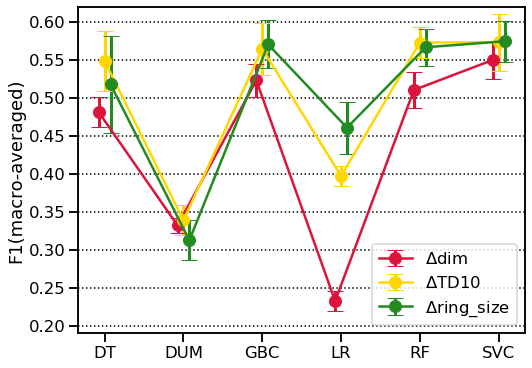

In [12]:
plt.figure(figsize=(8, 6))

for prop, colour, delta in zip(['dim', 'TD10', 'ring_size'],
                               ['crimson', 'gold', 'forestgreen'],
                               [-0.075, 0, 0.075]):

    plt.errorbar(x=np.arange(6) + delta, y=summary.loc[prop]['n5x5_cv_mean'],
                 yerr=summary.loc[prop]['n5x5_cv_std'],
                 marker='o', ms=12,
                 color=colour, lw=2.5,
                 ecolor=colour, elinewidth=3, capsize=8,
                 label='$\Delta$'+prop)
    plt.xticks(ticks=range(6), labels=['DT', 'DUM', 'GBC', 'LR', 'RF', 'SVC'])

plt.ylabel('F1(macro-averaged)')
plt.ylim(0.19, 0.62)
plt.legend(loc='best')
plt.grid(b=True, axis='y', ls=':', color='k', lw='1.5')
# plt.savefig('model_performance_nestedCV_Xtrue.png', dpi=dpi)

In [13]:
model_dicts_loaded['ring_size'].keys(), model_dicts_loaded.keys()

(dict_keys(['LR', 'DT', 'RF', 'SVC', 'GBC', 'DUM']),
 dict_keys(['dim', 'TD10', 'ring_size']))

Mind the problems of feature importance values from RFs ! features with high number of different values are artificially more important

Text(0.5, 1.0, 'dim, DT')

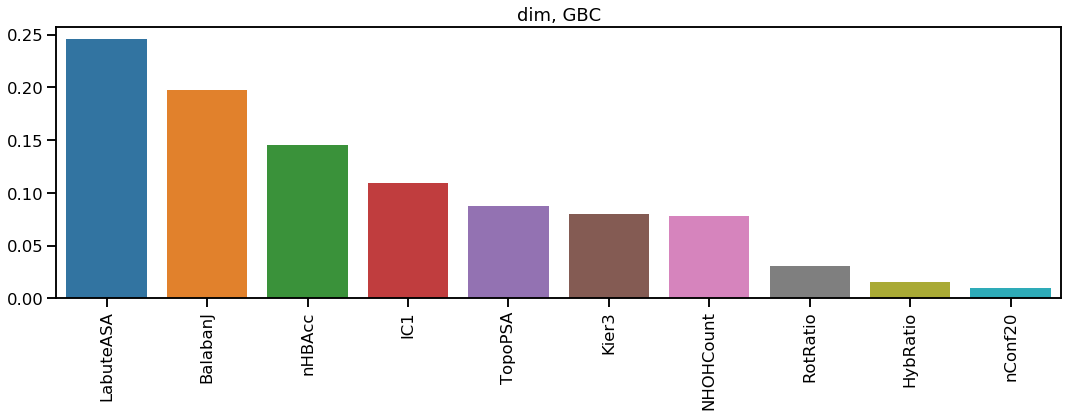

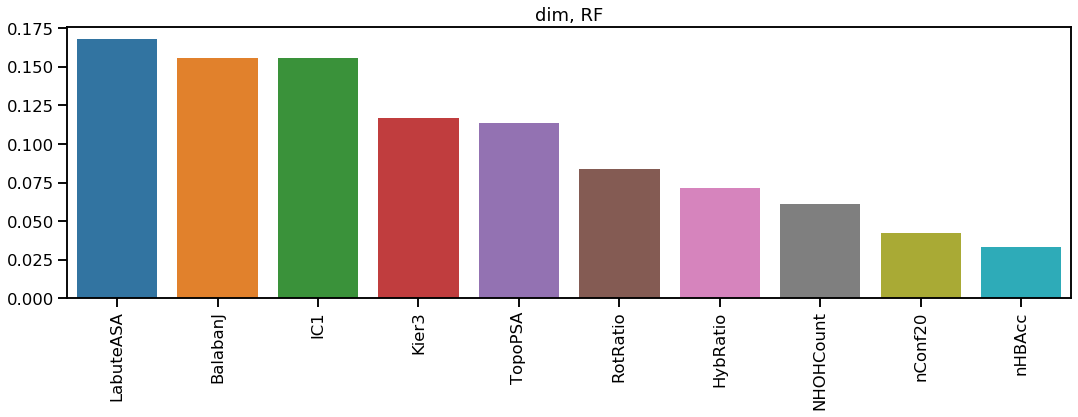

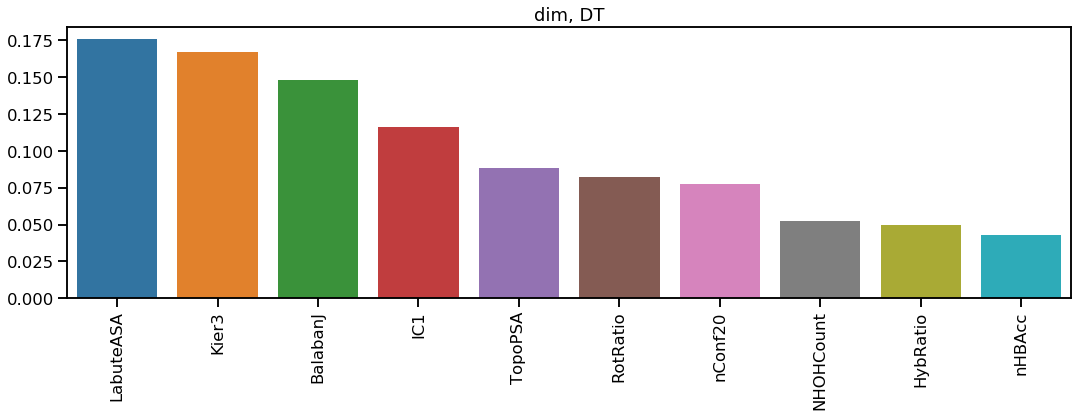

In [14]:
# with scaling
yx = y1X

plt.figure(figsize=(18, 5))
f_imp = model_dicts_loaded['dim']['GBC'].feature_importances_
imp = f_imp.argsort()[::-1]
sns.barplot(yx.columns[1:][imp], f_imp[imp])
_ = plt.xticks(rotation=90)
plt.title('dim, GBC')

plt.figure(figsize=(18, 5))
f_imp = model_dicts_loaded['dim']['RF'].feature_importances_
imp = f_imp.argsort()[::-1]
sns.barplot(yx.columns[1:][imp], f_imp[imp])
_ = plt.xticks(rotation=90)
plt.title('dim, RF')

plt.figure(figsize=(18, 5))
f_imp = model_dicts_loaded['dim']['DT'].feature_importances_
imp = f_imp.argsort()[::-1]
sns.barplot(yx.columns[1:][imp], f_imp[imp])
_ = plt.xticks(rotation=90)
plt.title('dim, DT')

**Learning curves for model assesment on the data amount**


######################################################################

dim prediction

######################################################################



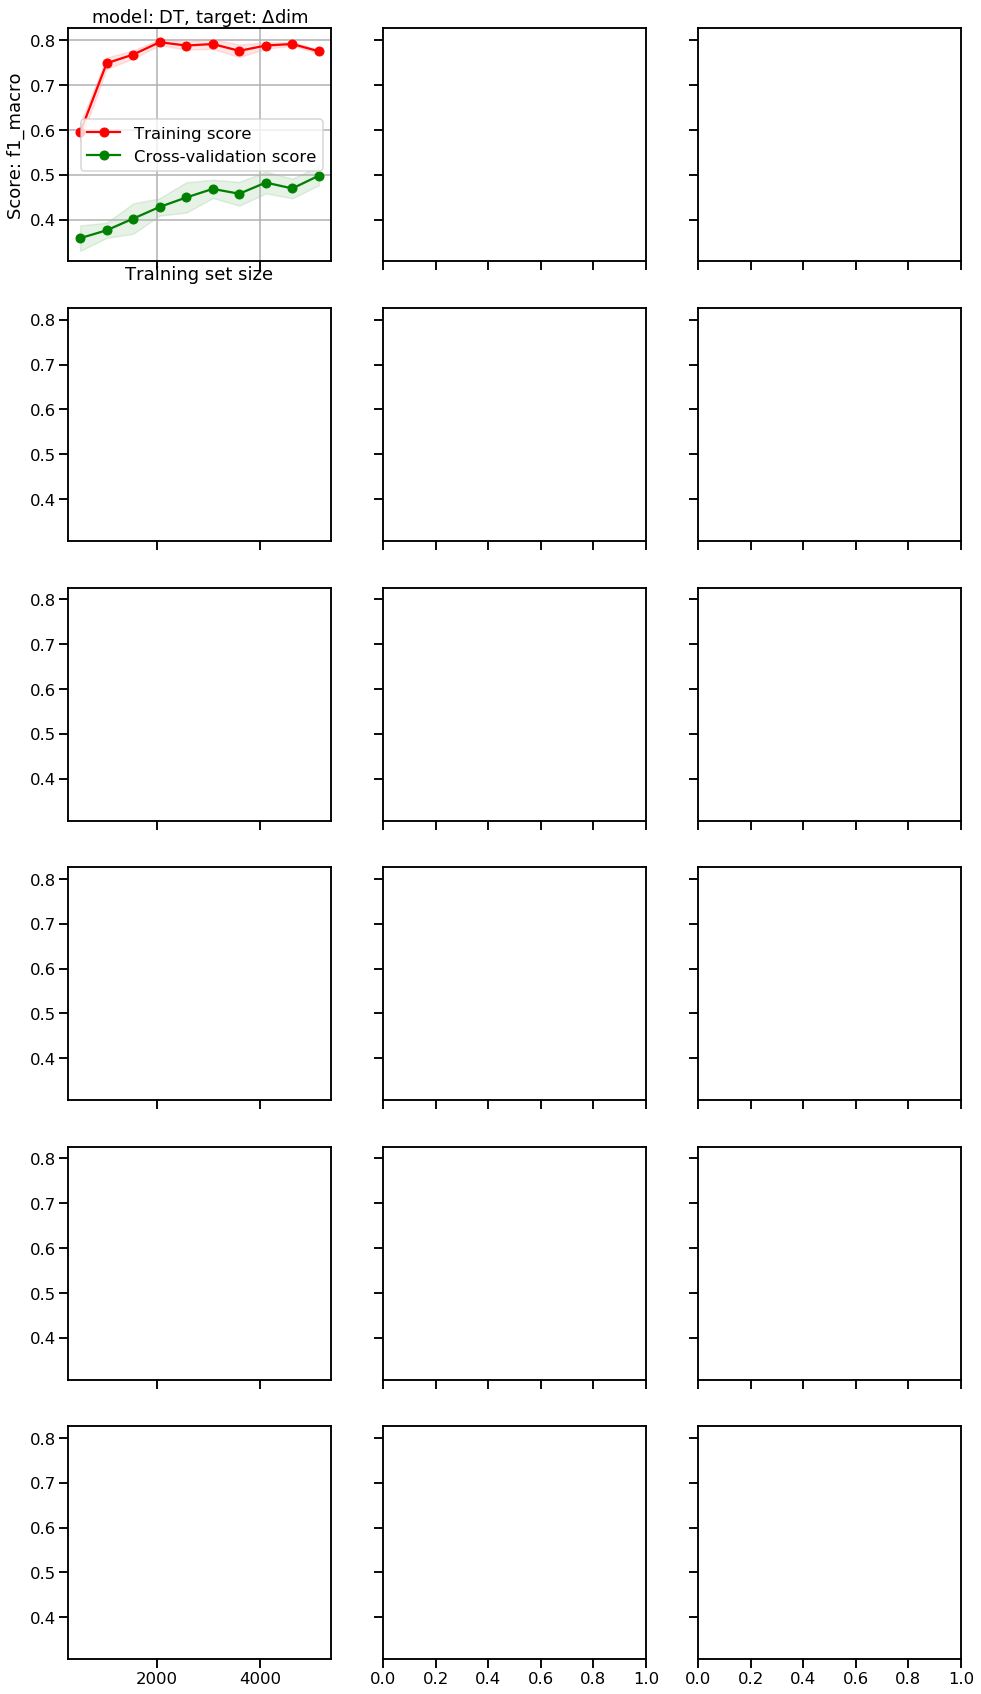


######################################################################

TD10 prediction

######################################################################


######################################################################

ring_size prediction

######################################################################



In [23]:
fig, ax = plt.subplots(6, 3, figsize=(16, 30), sharex='col', sharey=True)

for i, (frmwrk_prop, yx) in enumerate(zip(['dim', 'TD10', 'ring_size'], yXs)):

    print('\n%s\n' % (70*'#'))
    print(frmwrk_prop, 'prediction')
    print('\n%s\n' % (70*'#'))

    model_dict = model_dicts_loaded[frmwrk_prop]

    for j, (model_name, model) in enumerate(sorted(model_dict.items())):
        plot_learning_curve(estimator=model,
                            title=f'model: {model_name}, target: $\Delta${frmwrk_prop}',
                            axes=ax[j, i],
                            X=yx.iloc[:, 1:], y=yx.iloc[:, 0].astype(int),
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=23),
                            scoring='f1_macro',
                            train_sizes=np.linspace(.1, 1.0, 10),
                            n_jobs=-1)

fig.tight_layout()
fig.savefig('learning_curves.png', dpi=dpi)

**Results of learning curves analysis**
- `dim` - need more data to train - then better prediction quality, especially for `dim`! Note these are the datasets with high class imbalance
- `TD10`, `ring_size` - more data will only slightly improve model prediction abilities

!!! with modest set of descriptors we obtain non-overfitted classifiers !!!
!!! previously with large descriptor set RF and GBC and SVC tremendously overfit !!!

## Analysis and interpretation of models 

On the feature importance analysis
- http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html
- https://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf?ref=driverlayer.com/web
- https://arxiv.org/pdf/1905.03151.pdf

**consider grouping features and estimate their importance by removing groups, not the single features**
- didn't give more consistent importance estimations

on the y-scrambling

- https://onlinelibrary.wiley.com/doi/pdf/10.1002/qsar.200390007
- https://sci-hub.do/10.1021/ci700157b !!!!!!!!!!!!!!!!!!!!!!!!

straw models with random X data matrices
- https://science.sciencemag.org/content/sci/362/6416/eaat8603.full.pdf
- https://science.sciencemag.org/content/sci/362/6416/eaat8763.full.pdf

### y-randomization test

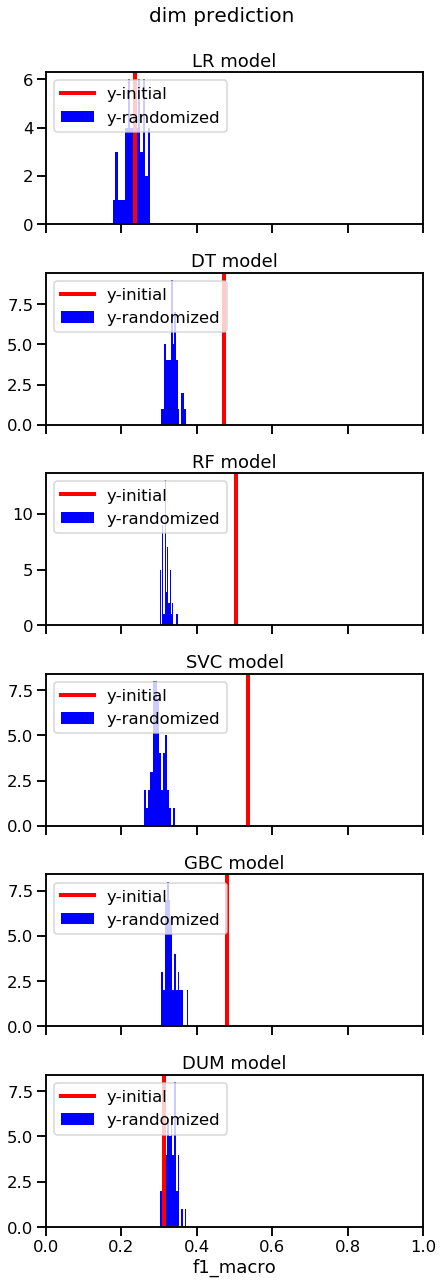

In [22]:
y_randomization_test(y1X, model_dicts_loaded, 'dim', scoring='f1_macro', n_repeats=50, savefig=True)

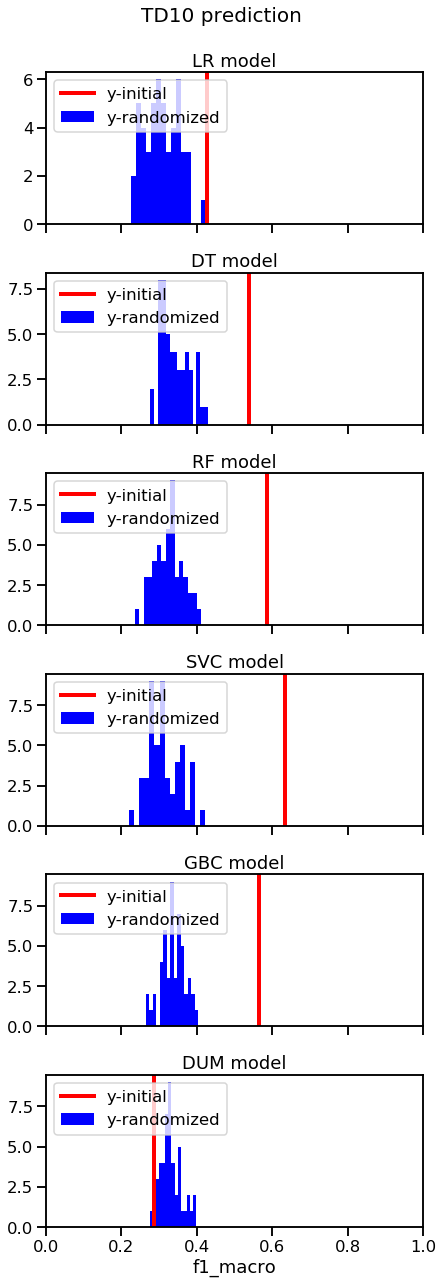

In [23]:
y_randomization_test(y2X, model_dicts_loaded, 'TD10', scoring='f1_macro', n_repeats=50, savefig=True)

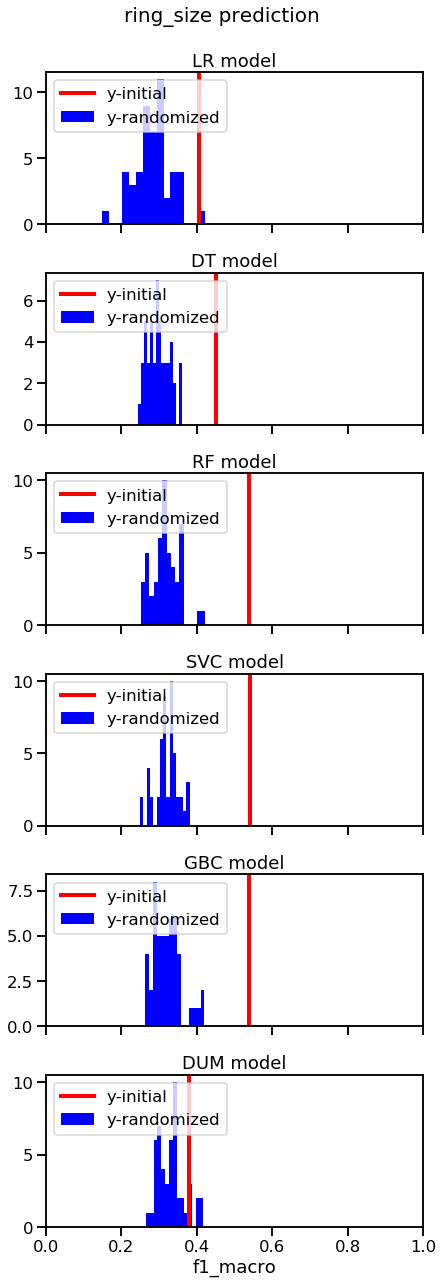

In [24]:
y_randomization_test(y4X, model_dicts_loaded, 'ring_size', scoring='f1_macro', n_repeats=50, savefig=True)

### permutation importance analysis

- feature maxabsscaling doesn't change significantly the feature importances
- maximizing F1 instead of F1_macro averaged score didn't result in significant differences

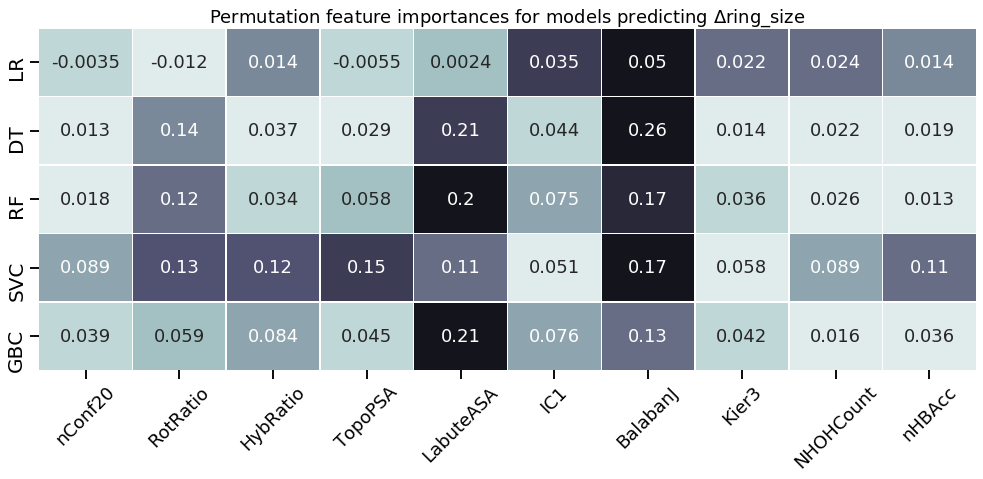

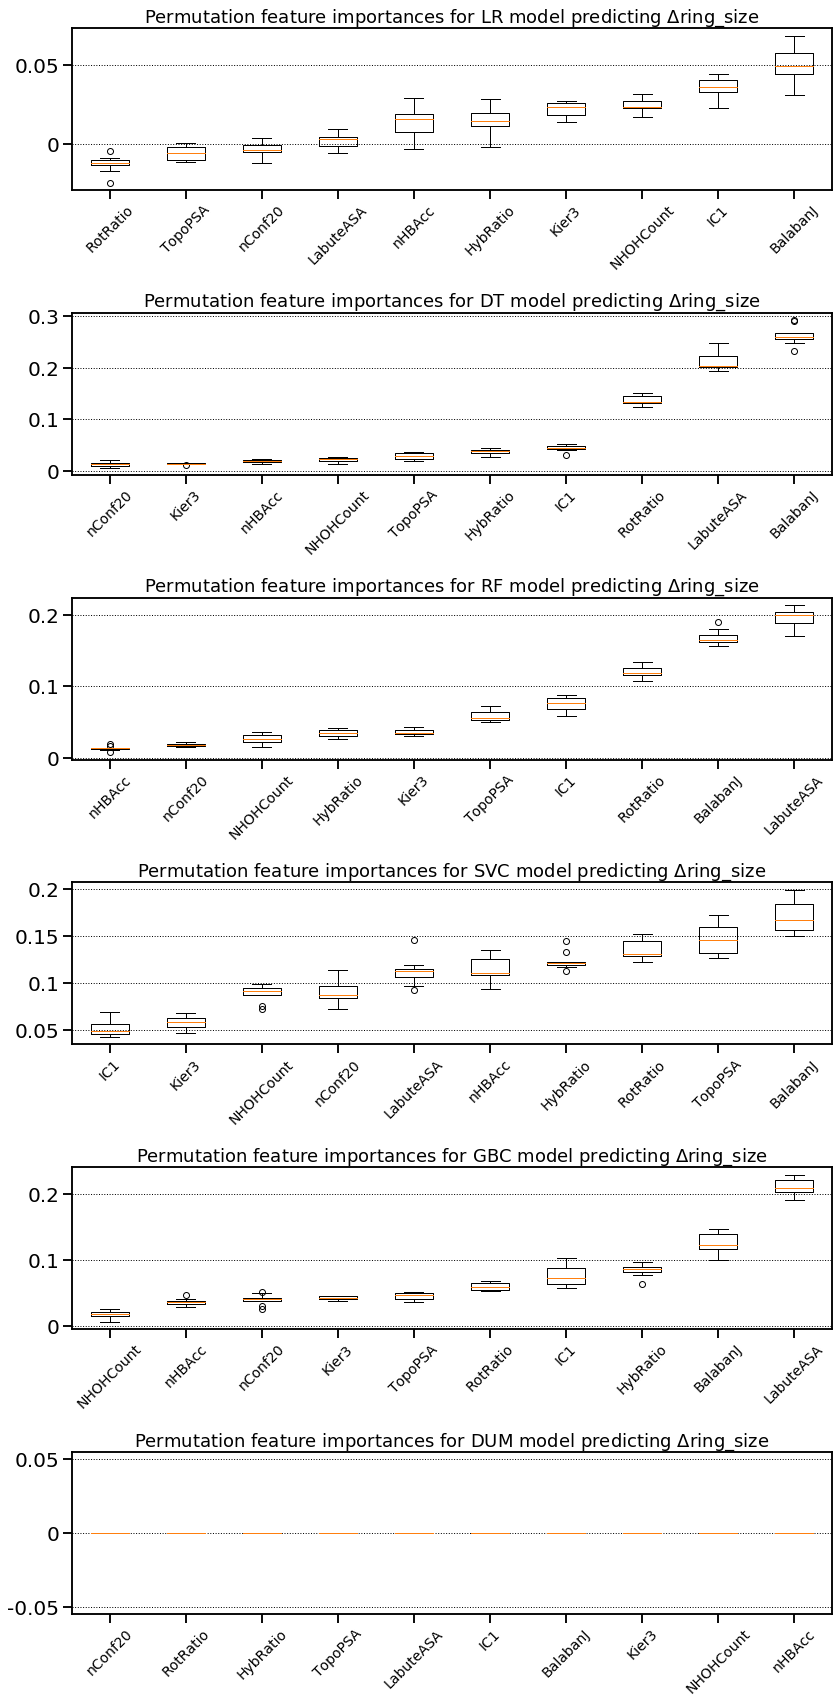

In [25]:
show_importances('ring_size', y4X, model_dicts_loaded, savefig=True)
show_importance_hists('ring_size', y4X, model_dicts_loaded, savefig=True) #

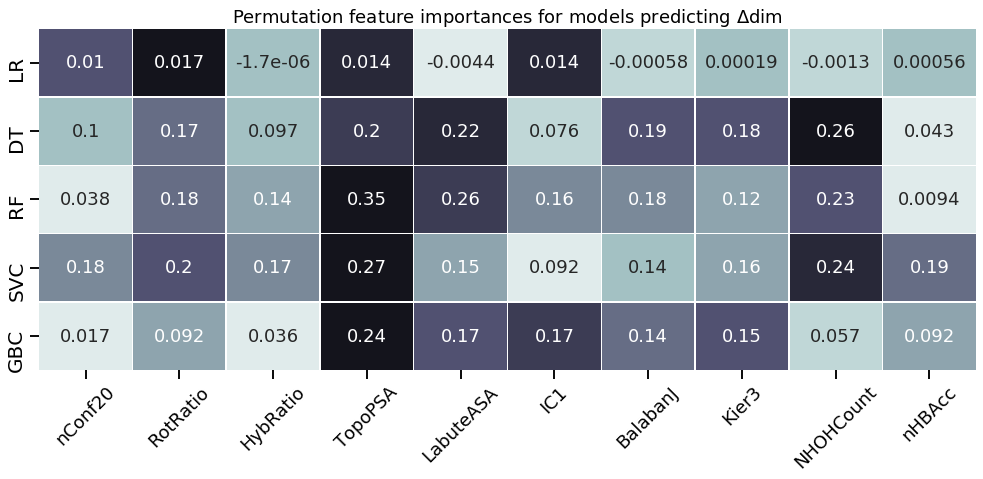

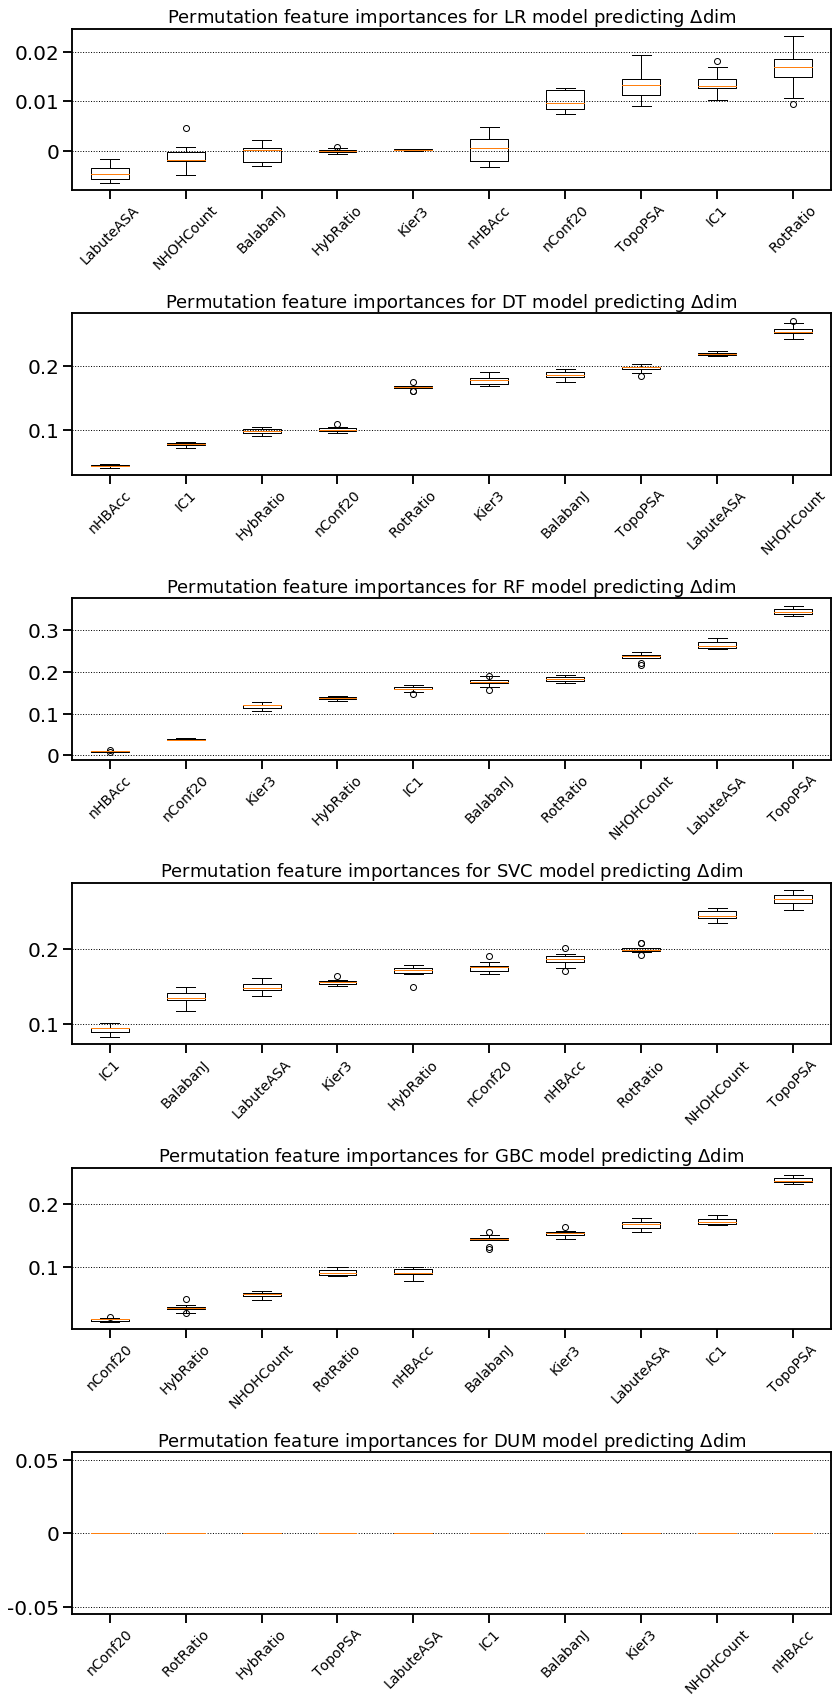

In [26]:
show_importances('dim', y1X, model_dicts_loaded, savefig=True)
show_importance_hists('dim', y1X, model_dicts_loaded, savefig=True) #

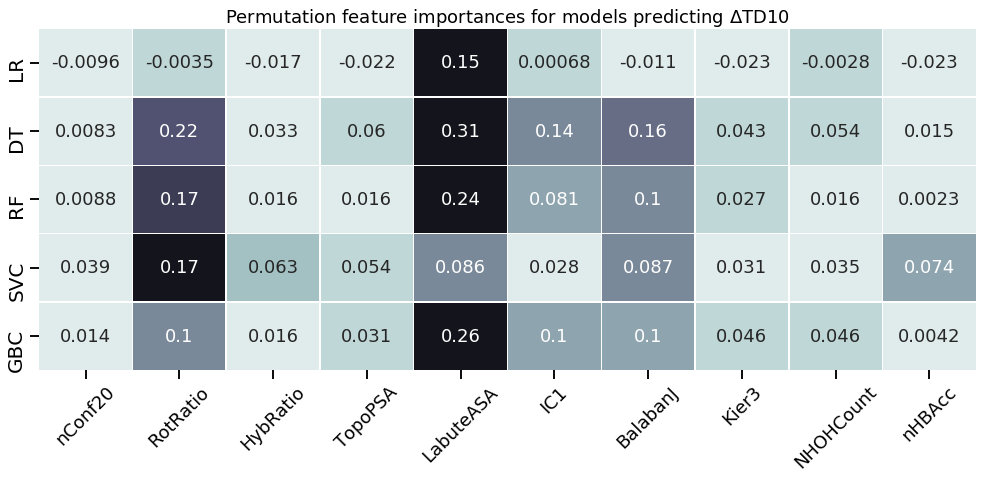

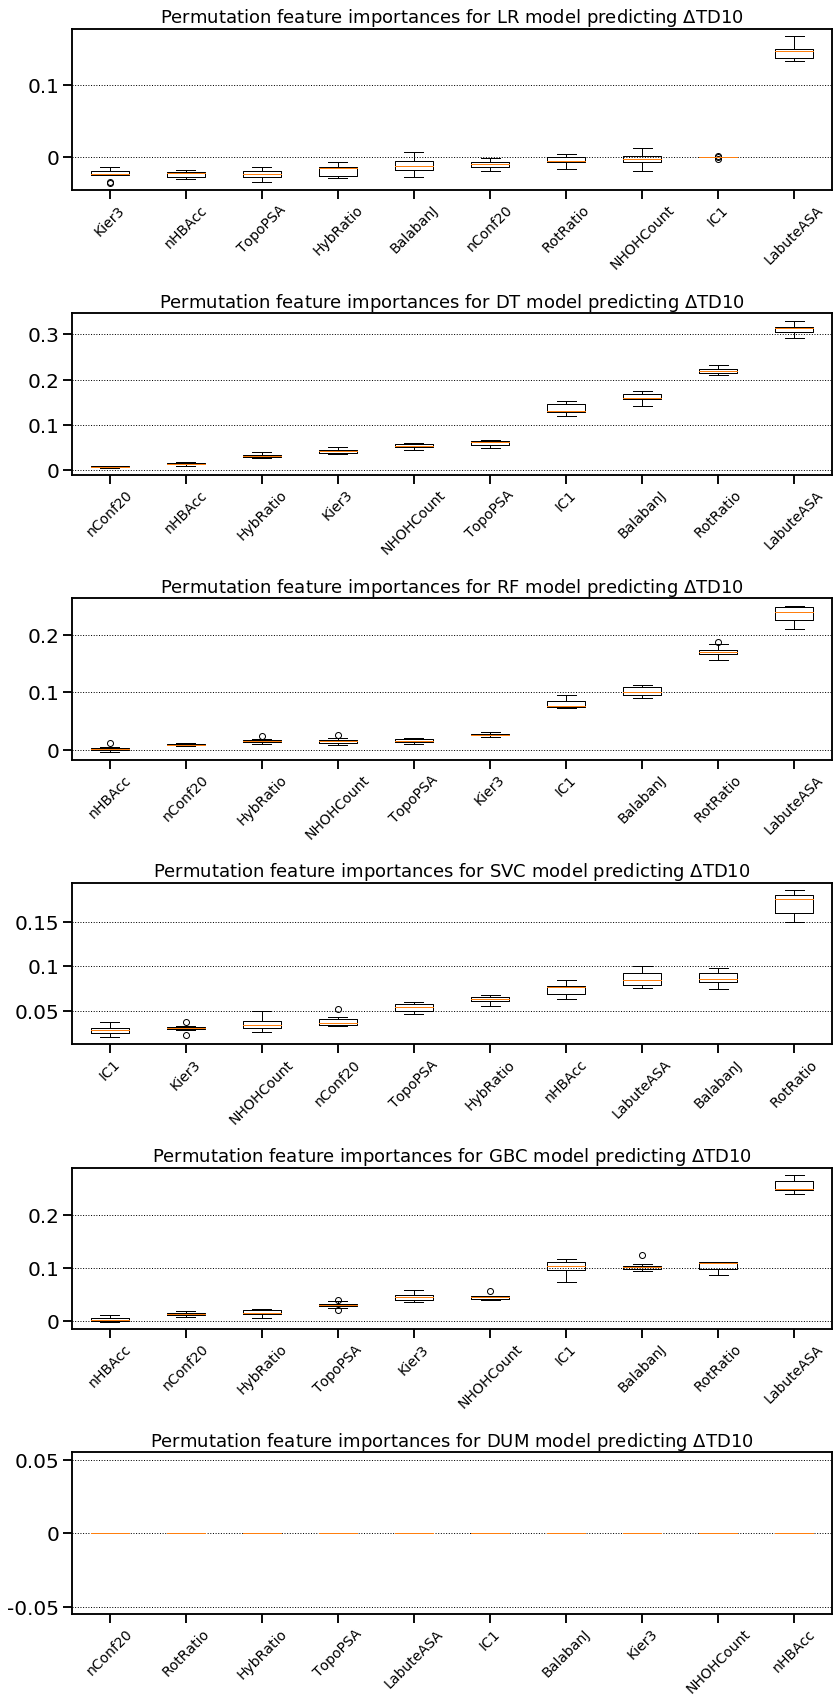

In [27]:
show_importances('TD10', y2X, model_dicts_loaded, savefig=True)
show_importance_hists('TD10', y2X, model_dicts_loaded, savefig=True) #

### Distributions

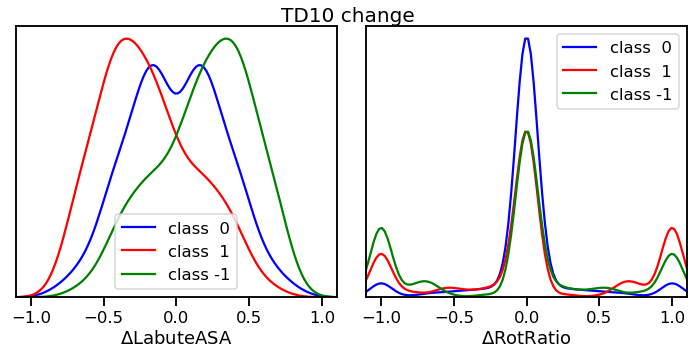

In [87]:
plt.figure(figsize=(10, 5))

plt.subplot(121)

sns.kdeplot(y2X['LabuteASA'][y2X['TD10_mean']== 0], color='b', label='class  0', bw='scott')
sns.kdeplot(y2X['LabuteASA'][y2X['TD10_mean']== 1], color='r', label='class  1', bw='scott')
sns.kdeplot(y2X['LabuteASA'][y2X['TD10_mean']==-1], color='g', label='class -1', bw='scott')

# sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']== 0], color='b', bins=15, label='class  0')
# sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']== 1], color='r', bins=15, label='class  1')
# sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']==-1], color='g', bins=15, label='class -1')

plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$LabuteASA')
plt.legend()
plt.yticks([])

plt.subplot(122)

sns.kdeplot(y2X['RotRatio'][y2X['TD10_mean']== 0], color='b', label='class  0', bw=.075)
sns.kdeplot(y2X['RotRatio'][y2X['TD10_mean']== 1], color='r', label='class  1', bw=.075)
sns.kdeplot(y2X['RotRatio'][y2X['TD10_mean']==-1], color='g', label='class -1', bw=.075)

# sns.distplot(y2X['RotRatio'][y2X['TD10_mean']== 0], color='b', bins=15, label='class  0', kde=False)
# sns.distplot(y2X['RotRatio'][y2X['TD10_mean']== 1], color='r', bins=15, label='class  1', kde=False)
# sns.distplot(y2X['RotRatio'][y2X['TD10_mean']==-1], color='g', bins=15, label='class -1', kde=False)

plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$RotRatio')
plt.legend()
plt.yticks([])

plt.suptitle('TD10 change', y=1.000, fontsize=20)
plt.tight_layout()

plt.savefig('LabuteASA_RotRatio_TD10_dist.png', dpi=dpi)

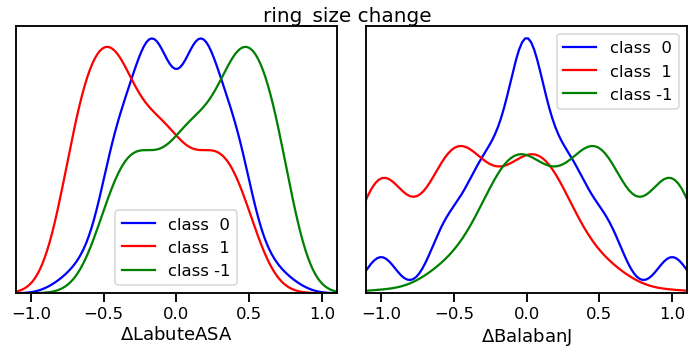

In [86]:
plt.figure(figsize=(10, 5))

plt.subplot(121)

sns.kdeplot(y4X['LabuteASA'][y4X['average_ring_size_for_PP_tiling']== 0], color='b', label='class  0', bw='scott')
sns.kdeplot(y4X['LabuteASA'][y4X['average_ring_size_for_PP_tiling']== 1], color='r', label='class  1', bw='scott')
sns.kdeplot(y4X['LabuteASA'][y4X['average_ring_size_for_PP_tiling']==-1], color='g', label='class -1', bw='scott')

# sns.distplot(y4X['LabuteASA'][y4X['average_ring_size_for_PP_tiling']== 0], color='b', bins=15, label='class  0')
# sns.distplot(y4X['LabuteASA'][y4X['average_ring_size_for_PP_tiling']== 1], color='r', bins=15, label='class  1')
# sns.distplot(y4X['LabuteASA'][y4X['average_ring_size_for_PP_tiling']==-1], color='g', bins=15, label='class -1')

plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$LabuteASA')
plt.legend()
plt.yticks([])

plt.subplot(122)

sns.kdeplot(y4X['BalabanJ'][y4X['average_ring_size_for_PP_tiling']== 0], color='b', label='class  0', bw='scott')
sns.kdeplot(y4X['BalabanJ'][y4X['average_ring_size_for_PP_tiling']== 1], color='r', label='class  1', bw='scott')
sns.kdeplot(y4X['BalabanJ'][y4X['average_ring_size_for_PP_tiling']==-1], color='g', label='class -1', bw='scott')

# sns.distplot(y4X['BalabanJ'][y4X['average_ring_size_for_PP_tiling']== 0], color='b', bins=15, label='class  0')
# sns.distplot(y4X['BalabanJ'][y4X['average_ring_size_for_PP_tiling']== 1], color='r', bins=15, label='class  1')
# sns.distplot(y4X['BalabanJ'][y4X['average_ring_size_for_PP_tiling']==-1], color='g', bins=15, label='class -1')

plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$BalabanJ')
plt.legend()
plt.yticks([])

plt.suptitle('ring_size change', y=1.000, fontsize=20)
plt.tight_layout()
plt.savefig('LabuteASA_BalabanJ_ring_size_dist.png', dpi=dpi)

In [84]:
y1X.columns

Index(['dim', 'nConf20', 'RotRatio', 'HybRatio', 'TopoPSA', 'LabuteASA', 'IC1',
       'BalabanJ', 'Kier3', 'NHOHCount', 'nHBAcc'],
      dtype='object')

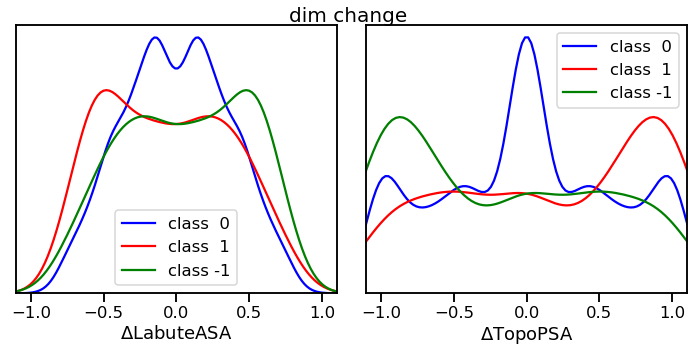

In [89]:
plt.figure(figsize=(10, 5))

plt.subplot(121)

sns.kdeplot(y1X['LabuteASA'][y1X['dim']== 0], color='b', label='class  0', bw='scott')
sns.kdeplot(y1X['LabuteASA'][y1X['dim']== 1], color='r', label='class  1', bw='scott')
sns.kdeplot(y1X['LabuteASA'][y1X['dim']==-1], color='g', label='class -1', bw='scott')

# sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']== 0], color='b', bins=15, label='class  0')
# sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']== 1], color='r', bins=15, label='class  1')
# sns.distplot(y2X['LabuteASA'][y2X['TD10_mean']==-1], color='g', bins=15, label='class -1')

plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$LabuteASA')
plt.legend()
plt.yticks([])

plt.subplot(122)

sns.kdeplot(y1X['TopoPSA'][y1X['dim']== 0], color='b', label='class  0', bw='scott')
sns.kdeplot(y1X['TopoPSA'][y1X['dim']== 1], color='r', label='class  1', bw='scott')
sns.kdeplot(y1X['TopoPSA'][y1X['dim']==-1], color='g', label='class -1', bw='scott')

# sns.distplot(y2X['RotRatio'][y2X['TD10_mean']== 0], color='b', bins=15, label='class  0', kde=False)
# sns.distplot(y2X['RotRatio'][y2X['TD10_mean']== 1], color='r', bins=15, label='class  1', kde=False)
# sns.distplot(y2X['RotRatio'][y2X['TD10_mean']==-1], color='g', bins=15, label='class -1', kde=False)

plt.xlim(-1.1, 1.1)
plt.xlabel('$\Delta$TopoPSA')
plt.legend()
plt.yticks([])

plt.suptitle('dim change', y=0.995, fontsize=20)
plt.tight_layout()
plt.savefig('LabuteASA_TopoPSA_dim_dist.png', dpi=dpi)

In [14]:
y2X[['BalabanJ', 'Kier3']].astype(str).describe()

,BalabanJ,Kier3
count,1158,1158
unique,337,167
top,0.0,0.0
freq,122,836


### PDP analysis

In [8]:
from sklearn.inspection import plot_partial_dependence

In [15]:
def show_pdp(model, data, features, ax, target):

    display = plot_partial_dependence(model,
                                      data,
                                      features,
                                      n_jobs=3,
                                      grid_resolution=20,
                                      ax=ax,
                                      target=target
                                     )
    display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

    return display

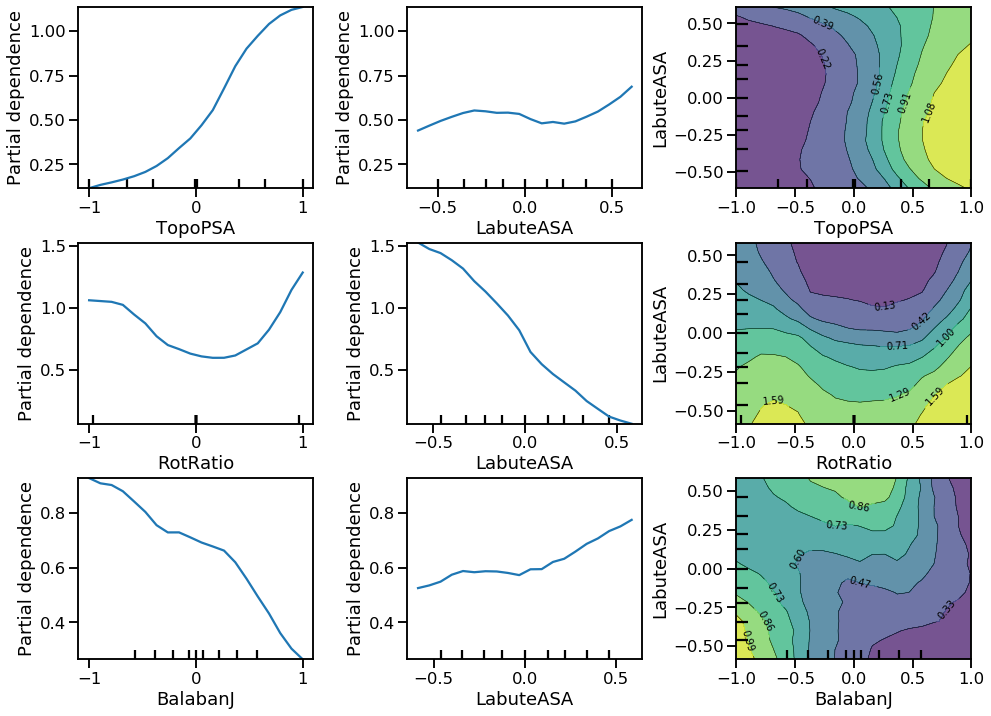

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

show_pdp(model_dicts_loaded['dim']['SVC'], y1X.iloc[:, 1:],
         ['TopoPSA', 'LabuteASA', ('TopoPSA', 'LabuteASA')],
         ax=ax[0],
         target=1)

show_pdp(model_dicts_loaded['TD10']['SVC'], y2X.iloc[:, 1:],
         ['RotRatio', 'LabuteASA', ('RotRatio', 'LabuteASA')],
         ax=ax[1],
         target=1)

show_pdp(model_dicts_loaded['ring_size']['SVC'], y4X.iloc[:, 1:],
         ['BalabanJ', 'LabuteASA', ('BalabanJ', 'LabuteASA')],
         ax=ax[2],
         target=1)

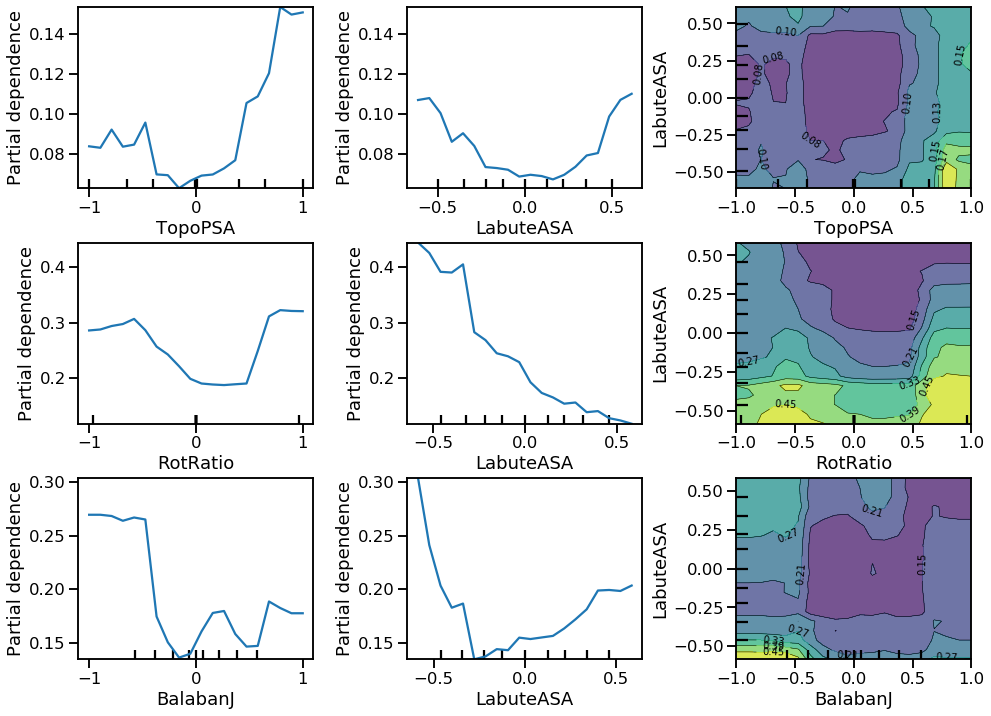

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

show_pdp(model_dicts_loaded['dim']['RF'], y1X.iloc[:, 1:],
         ['TopoPSA', 'LabuteASA', ('TopoPSA', 'LabuteASA')],
         ax=ax[0],
         target=1)

show_pdp(model_dicts_loaded['TD10']['RF'], y2X.iloc[:, 1:],
         ['RotRatio', 'LabuteASA', ('RotRatio', 'LabuteASA')],
         ax=ax[1],
         target=1)

show_pdp(model_dicts_loaded['ring_size']['RF'], y4X.iloc[:, 1:],
         ['BalabanJ', 'LabuteASA', ('BalabanJ', 'LabuteASA')],
         ax=ax[2],
         target=1)

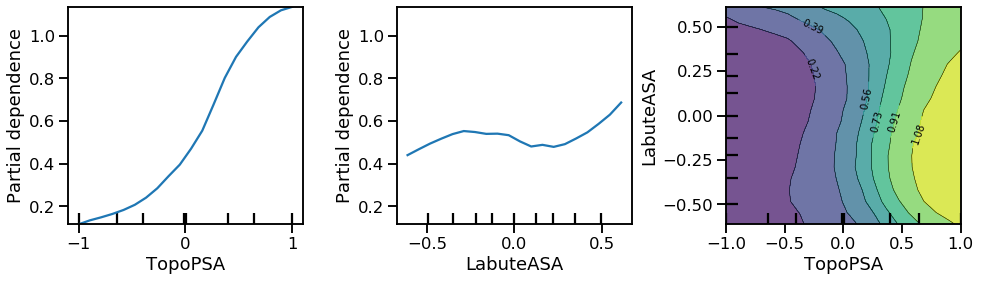

In [11]:
features = ['TopoPSA', 'LabuteASA', ('TopoPSA', 'LabuteASA')]

_, ax = plt.subplots(ncols=3, figsize=(16, 4))
display = plot_partial_dependence(model_dicts_loaded['dim']['SVC'],
                                  y1X.iloc[:, 1:], features,
                                  n_jobs=3, grid_resolution=20,
                                  ax=ax,
                                  target=1
                                 )

display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

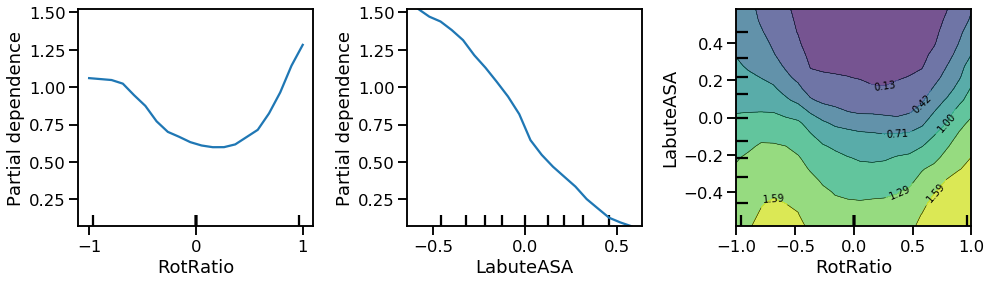

In [12]:
features = ['RotRatio', 'LabuteASA', ('RotRatio', 'LabuteASA')]

_, ax = plt.subplots(ncols=3, figsize=(16, 4))
display = plot_partial_dependence(model_dicts_loaded['TD10']['SVC'],
                                  y2X.iloc[:, 1:], features,
                                  n_jobs=3, grid_resolution=20,
                                  ax=ax,
                                  target=1
                                 )

display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

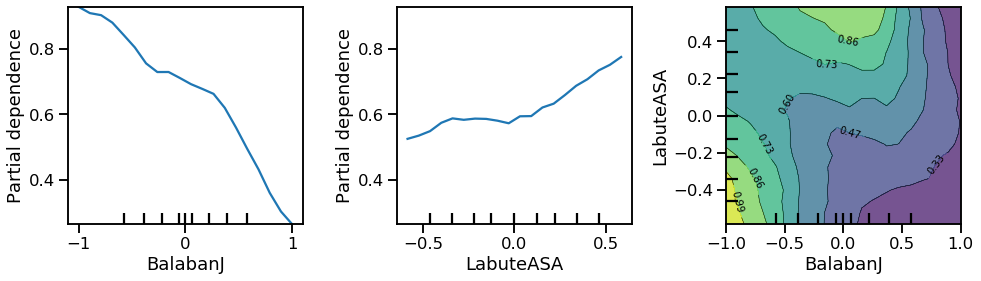

In [27]:
features = ['BalabanJ', 'LabuteASA', ('BalabanJ', 'LabuteASA')]

_, ax = plt.subplots(ncols=3, figsize=(16, 4))
display = plot_partial_dependence(model_dicts_loaded['ring_size']['SVC'],
                                  y4X.iloc[:, 1:], features,
                                  n_jobs=3, grid_resolution=20,
                                  ax=ax,
                                  target=1
                                 )

display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

### continue